In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from os import environ
import tensorflow as tf
from tensorflow import keras
import joblib

from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, BatchNormalization, ReLU, MaxPooling2D
from keras.layers import Activation, Masking 
from keras.layers import Dropout, PReLU
from keras.layers import Conv1D, Input, SpatialDropout2D
from keras.layers import MaxPooling1D, Reshape, ConvLSTM2D, Conv2D
from keras.layers import Flatten, RepeatVector
from keras.layers import TimeDistributed, Permute, Concatenate, Multiply, Lambda
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, model_from_json

import plotly.express as px
import plotly.graph_objects as go

## LSTM Neural Network Architectures

We defined custom architectures for the long short term memory neural networks. Defined as Keras Sequential models, they take a series of parameters to customize them in terms of number of Recurrent Neural Layers, the number of units for each one of them, the number of units in the final dense layer, how many steps into the future of the target we are forecasting, and some other parameters such as dropout, learning rate and model name. We have considered 3 types of recurrent neural networks here: a simple LSTM, a bidirectional LSTM and a bidirectional LSTM with attention.

Later, we test different versions of these models, compare them and choose one or two to make it available for the final user.

In [20]:
# Functions to define NN with different architectures

def build_LSTM(in_shape, 
               num_rnns=1, 
               dim_rnn=128,
               dense_units=100,
               num_ysteps=1, 
               lr=1e-3,
               decay=6e-8,
               drop=False,
               drop_rate=0.2,
               masking=False,
               mv=-np.inf,
               model_name='LSTM',
               summarize: bool = False
               ):
  
  """Builds a classifier with LSTM layers with the given parameters

      Parameters:
      - in_shape: the constant shape of the input data X
      - num_rnns: how many lstm layers to add
      - dim_rnns: the number of units for each lstm layer
      - dense_units: number of units for the dense layer that goes after lstms
      - num_ysteps: how many time steps of the target to predict
      - drop: would you like to use dropout layers to prevent overfitting?
      - **masking: do not set this parameter to True because you cannot
                  manipulate the data to use a masking value.
      - extra Neural Network training parameters...

      Returns a keras model for classification that has not yet been trained"""

  # sequence input
  in_seq = Input(shape=in_shape, name='sequential_input')

  if masking:
    # tell rnns to ignore masked-padded timesteps
    x = Masking(mask_value=mv)(in_seq)
  else:
    x = in_seq

  lstm_out = LSTM(dim_rnn, activation='relu',
                  return_sequences=True)(x)
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)

  rnn_layers = 1
  while rnn_layers < num_rnns:
    rnn_layers +=1
    rs = not (rnn_layers == num_rnns)
    lstm_out = LSTM(dim_rnn, activation='relu',
                    return_sequences=rs)(lstm_out)
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)

  xx = Dense(dense_units, activation='relu')(lstm_out)
  pred_out = Dense(num_ysteps, activation='relu')(xx)

  # Define Model
  lags = in_shape[0]
  features = in_shape[1]
  predictor = Model(in_seq, pred_out, name=model_name + '_' + str(lags) + '_lags_' + str(features) + '_fts')
  # compile model
  opt = Adam(learning_rate=lr, decay=decay)
  predictor.compile(loss='mse', 
                    optimizer=opt, 
                    metrics=['mse'])
  if summarize:
    predictor.summary()

  return predictor


def build_BLSTM(in_shape, 
                num_rnns=1, 
                dim_rnn=128,
                dense_units=100, 
                num_ysteps=1,
                lr=1e-3, 
                decay=6e-8,
                drop=False,
                drop_rate=0.2,
                masking=False,
                mv=-np.inf,
                model_name='Bidirectional_LSTM',
               summarize: bool = False
                ):

  """Builds classifier with Bidirectional LSTM layers from the given parameters

    Parameters:
    - in_shape: the constant shape of the input data X
    - num_rnns: how many lstm layers to add
    - dim_rnns: the number of units for each lstm layer
    - dense_units: number of units for the dense layer that goes after lstms
    - num_ysteps: how many timesteps of the target to predict
    - drop: would you like to use dropout layers to prevent overfitting?
    - extra Neural Network training parameters...

    Returns a keras model for classification that has not yet been trained"""

  # sequence input
  in_seq = Input(shape=in_shape, name='sequential_input')

  if masking:
    # tell rnns to ignore masked-padded timesteps
    x = Masking(mask_value=mv)(in_seq)
  else:
    x = in_seq
  lstm_out = Bidirectional(LSTM(dim_rnn, activation='relu',
                                return_sequences=True))(x)
  rnn_layers = 1
  while rnn_layers < num_rnns:
    rnn_layers +=1
    rs = not (rnn_layers == num_rnns)
    lstm_out = Bidirectional(LSTM(dim_rnn, activation='relu',
                                  return_sequences=rs))(lstm_out)
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)

  xx = Dense(dense_units, activation='relu')(lstm_out)
  pred_out = Dense(num_ysteps, activation='relu')(xx)

  # Define Model
  lags = in_shape[0]
  features = in_shape[1]
  predictor = Model(in_seq, pred_out, name=model_name + '_' + str(lags) + '_lags_' + str(features) + '_fts')
  # compile model
  opt = Adam(learning_rate=lr, decay=decay)
  predictor.compile(loss='mse', 
                     optimizer=opt, metrics=['mse'])
  if summarize:
    predictor.summary()

  return predictor


def build_AttentiveBLSTM(
    in_shape,    # (num_timesteps, num_features)
    num_rnns=1, 
    dim_rnn=64, 
    num_ysteps=1, 
    lr=1e-3, 
    decay=6e-8,
    drop=False,
    drop_rate=0.2,
    masking=False,
    mv=-np.inf,
    model_name='Attentive_BLSTM',
    suffix='',
    summarize: bool = False):
  
  """Builds classifier with Bidirectional LSTM layers and Attention 
      implementation from the given parameters

     Parameters:
     - in_shape: Tuple (num_timesteps, num_features)
                 the constant shape of each sample in the input data X
     - num_rnns: how many lstm layers to add
     - dim_rnns: the number of units for each lstm layer
     - dense_units: number of units for the dense layer that goes after lstms
     - num_ysteps: how many timesteps of the target to predict
     - drop: would you like to use dropout layers to prevent overfitting?
     - extra Neural Network training parameters...
     Returns a keras model for classification that has not yet been trained"""
  
  # sequence input
  in_seq = Input(shape=in_shape, name='sequential_input')
  
  if masking:
    # tell rnns to ignore masked-padded timesteps
    x = Masking(mask_value=mv)(in_seq)
  else:
    x = in_seq
  lstm_out = Bidirectional(LSTM(dim_rnn, return_sequences=True,input_shape=in_shape))(x)
  rnn_layers = 1
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)
  while rnn_layers < num_rnns:
    rnn_layers +=1
    lstm_out = Bidirectional(LSTM(dim_rnn, return_sequences=True))(lstm_out)   
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)
  # adding attention
  e = Dense(1, activation='tanh')(lstm_out)
  e = Flatten(data_format=None)(e)
  a = Activation('softmax')(e)
  temp = RepeatVector(2*dim_rnn)(a)
  temp = Permute([2, 1])(temp)
  # multiply weights with lstm output
  att_out = Multiply()([lstm_out, temp])
  # attention adjusted output state
  att_out = Lambda(lambda values: K.sum(values, axis=1))(att_out)
  pred_out = Dense(num_ysteps, activation='relu')(att_out)

  # Define Model
  lags = in_shape[0]
  features = in_shape[1]
  predictor = Model(in_seq, pred_out, name=model_name + '_' + str(lags) + '_lags_' + str(features) + '_fts' + '_' + suffix)
  # compile model
  opt = Adam(learning_rate=lr, decay=decay)
  predictor.compile(loss='mae', 
                     optimizer=opt, metrics=['mse'])
  if summarize:
    predictor.summary()

  return predictor

## Data Preprocessing Functions

In [21]:
def build_dset(n_coins: int, gtrends: bool = False):

    """
    Builds a dataframe with price and volume daily data from yahoofinance for each of a given
    number of coins and returns a dictionary with the coin name as the key and the dataframe as the value.
    The dataframe also cointains the risk free rate as the US treasury bonds yield at different maturities,
    which is thought to capture the effect of inflation and inflation expectations that might have certain effect
    on crypto prices.
    Coins are sorted by market cap and days of history available.
    """

    # Get top n_coins coins by mktcap
    load_dotenv()
    mktcap_key = environ.get('COIN_MKTCAP_KEY')
    cmc = CoinMarketCap(mktcap_key)
    coins_df = cmc.get_top_coins(n_coins)

    # Daily US yield curve to account for interest rate (inflation) effect
    yield_curve = ['^FVX', '^TNX', '^TYX']
    ir_dfs = []
    for ir in yield_curve:
        min_date = coins_df['first_historical_data'].min()
        status, ir_data = yahoo_finance.market_value(ir, hist=min_date, interval='1d')
        ir_data.rename(columns={'Close': ir[1:]}, inplace=True)
        ir_close =  ir_data[ir[1:]]
        ir_dfs.append(ir_close)
    us_treasury = pd.concat(ir_dfs, axis=1)

    # Get daily market data for top 10 coins
    data_dict = {}
    for idx, coin in coins_df.iterrows():
        coin_name = coin['name']
        ticker = coin['symbol'] + '-USD'
        start = coin['first_historical_data']

        # Get daily market data from yahoo
        status, data = yahoo_finance.market_value(ticker, hist=start, interval='1d')
        print(coin_name, coin['days_history'])
        print(data.shape)
        # Add yield curve data
        data = data.merge(us_treasury, how='left', left_index=True, right_index=True)
        xcols = ['High', 'Low', 'Volume'] + [s[1:] for s in yield_curve]

        if gtrends:
            gt = GoogleTrends()
            # Get daily google trend data
            start_str = dt.datetime.strftime(start, r'%Y-%m-%d')
            end_str = dt.datetime.strftime(dt.datetime.today(), r'%Y-%m-%d')
            gtrend = gt.get_daily_trend_df([coin_name], start_date=start_str, end_date=end_str)
            data = data.merge(gtrend, how='left', left_index=True, right_index=True)
            data = data.rename(columns={coin_name: 'Google_Trend'})
            xcols = ['High', 'Low', 'Volume'] + [s[1:] for s in yield_curve] + ['Google_Trend']

        data = data.fillna(method='ffill')[xcols + ['Close']]
        data_dict[coin_name] = data
        
    return data_dict


def select_features(data_dict, keep=['Volume', 'Gtrend']):
    """
    Simple feature selection rule for each coin.
    Keep the volume and select the US treasury bond maturity with the highest correlation to the target.
    """

    for coin, dset in data_dict.items():
        selected_features = keep
        corr = dsets[coin].corr()
        yield_curve = ['FVX', 'TNX', 'TYX']
        corr_yield = np.abs(corr[yield_curve])
        ir_index = corr_yield.loc['Close', :].argmax()
        selected_features = keep + [yield_curve[ir_index]]
        
        data_dict[coin] = dset[list(set(selected_features)) + ['Close']]


def series_to_supervised(df, n_in=1, n_out=1, target_idx=-1, 
                         dropnan=True, min_input=None, trajectory=False):

    """
    Takes the dataframe and sets as many as n_in lags of the features as columns. (Reframes the df)
    This is required for LSTM neural networks which take 3D input (n_samples, n_lags, n_features).
    """
    
    df = df.copy(deep=True)
    n_in = int(n_in)
    min_input = int(min_input)
    target = df.columns[target_idx]
    df[target + '_t'] = df[target]
    n_vars = df.shape[1] - 1
    
    vars = list(df.columns)
    vars.remove(target)
    cols, names = list(), list()
    # input sequences (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.iloc[:,:target_idx].shift(i))
      names += [(var + '(t-%d)' % i) for var in vars]
    if trajectory or n_out==1:    
        # current features (t)
        cols.append(df)
        names += [(var + '(t)') for var in vars]
        names += [target + '(t)']
        # forecast sequence (t, t+1, ... t+n)
        for i in range(1, n_out):
            cols.append(df[target].shift(-i))    
            names += [target + '(t+%d)' % i]
    else:
        # current features (t)
        cols.append(df.iloc[:,:-1])
        names += [(var + '(t)') for var in vars]
        cols.append(df[target].shift(-n_out))    
        names += [target + '(t+%d)' % n_out]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan and min_input:
      agg.dropna(inplace=True, thresh=n_vars*(min_input+1))
    agg.drop(columns=[(var + '(t)') for var in vars], inplace=True)
    return agg


def prep_data(df, timesteps, test_days=365, scaler=None):
    """
    Final data preparations: 
    - extracts np.arrays from df,
    - rescales the data with a minmax scaler,
    - reshapes data into the 3D sequential arrays as required by LSTMs
    - Train-Test split using the last test_days parameter as training samples.
    """

    reframed = series_to_supervised(df, n_in=timesteps, min_input=timesteps)
    seqs = reframed.values 

    if not scaler:
        scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_seqs = scaler.fit_transform(seqs)

    X = scaled_seqs[:,:-1].reshape((seqs.shape[0], 
                            timesteps, 
                            int(seqs.shape[1]/timesteps)
                            ))
    y = scaled_seqs[:, -1]

    X_train, X_test = X[:-test_days, :, :], X[-test_days:, :, :]
    y_train, y_test = y[:-test_days], y[-test_days:]

    test_dates = df.iloc[-test_days:, :].index
    
    return X_train, y_train, X_test, y_test, scaler, test_dates

## Model Training Functions

In [22]:
def train_model(
    prep_dsets: dict, 
    coin_name: str,
    model_builder,
    n_epochs=1,
    batch_size=1,
    early_stop: bool = False,
    patience: int = None,
    model_kwargs: dict = {}):

    X_train, y_train, X_test, y_test, _, _ = prep_dsets[coin_name]
    # Build lstm model
    model = model_builder(
                    in_shape=(X_train.shape[1], X_train.shape[2]),
                    **model_kwargs
                    )
    if early_stop and patience:
        # This EarlyStopping callback stops training once it stops improving
        # so that you can set a high number of epochs and let it choose when to stop
        monitor = EarlyStopping(monitor='val_loss', 
                                min_delta=1e-3, 
                                patience=patience, 
                                verbose=0, 
                                mode='auto', 
                                restore_best_weights=True)
    # Train the model
    history = model.fit(
                    X_train, y_train, 
                    validation_data=(X_test, y_test),
                    callbacks=[monitor] if early_stop else None,
                    verbose=2, 
                    epochs=n_epochs,
                    batch_size=batch_size
                    )
    # visualize training
    plt.plot(history.history['mse'], label='train')
    plt.plot(history.history['val_mse'], label='test')
    plt.legend()
    plt.show()

    return model

In [23]:
def save_model(model, full_path: str= None, path="./models/", coin_ticker='BTC'):
    
    # serialize model
    model_json = model.to_json()
    if not full_path:
        full_path = path + coin_ticker + '_' + model.name + '.json'
    with open(full_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights
    weights_path = full_path.replace('.json', '.h5')
    model.save_weights(weights_path)


def save_scaler(fitted_scaler, full_path: str= None, path="./models/", coin_ticker='BTC'):
    if not full_path:
        full_path = path + coin_ticker + '_scaler.gz'
    joblib.dump(fitted_scaler, full_path)


def load_scaler(full_path: str= None, path="./models/", coin_ticker='BTC'):
    
    if not full_path:
        full_path = path + coin_ticker + '_scaler.gz'
    my_scaler = joblib.load(full_path)
    return my_scaler


def load_model(full_path: str= None, path="./models/", coin_ticker='BTC', model_name='blstm'):
    
    if not full_path:
    # load json and create model
        full_path = path + coin_ticker + '_' + model_name + '.json'
    json_file = open(full_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    weights_path = full_path.replace('.json', '.h5')
    loaded_model.load_weights(weights_path)

    return loaded_model

## Model Testing Functions

In [38]:
def get_test_df(model, x_test, y_test, scaler, test_dates):
    
    predicted = model.predict(x_test)
    X_test_2d = X_test.reshape((X_test.shape[0], timesteps * X_test.shape[2]))
    xpred_2d = np.append(X_test_2d, predicted, axis=1)
    pred_y = scaler.inverse_transform(xpred_2d)[:, -1]
    xtrue_2d = np.append(X_test_2d, y_test.reshape(predicted.shape), axis=1)
    true_y = scaler.inverse_transform(xtrue_2d)[:, -1]

    test_df = pd.DataFrame()
    test_df['Observed'] = true_y
    test_df['Predicted'] = pred_y
    test_df.index = test_dates

    return test_df


def plot_model_test(test_df, px_theme='plotly_dark'):

    fig = px.line(
            test_df, 
            x=test_df.index, 
            y=test_df.columns,
            template=px_theme,
            labels={
                    'variable': ''
                },
            )
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    fig.update_yaxes(title_text = 'Close Price')
    fig.update_layout(
        yaxis_tickformat = '$',
        title={
            'text': "Model Performance",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
            #family="Courier New, monospace",
            size=25)
            },
        )
    fig.update_traces(hovertemplate='%{y:$,.2f}')
    fig.update_layout(hovermode="x unified")

    fig.update_xaxes(
        title_text = 'Date',
        rangeslider_visible = True
        )

    return fig

## Feature Importance Functions

In [25]:
def get_importance_df(model, dset, timesteps):

    reframed = series_to_supervised(dset, n_in=timesteps, min_input=60)
    feature_names = reframed.iloc[:, :-1].columns
    feature_names = list(feature_names)
    _, _, X_test, y_test, _, _ = prep_data(dset, timesteps)
    results = []

    mae_err = mean_absolute_error
    mse_err = mean_squared_error 
    oof_preds = model.predict(X_test, verbose=0).squeeze() 
    baseline_mae = mae_err(y_test, oof_preds)
    baseline_mse = mse_err(y_test, oof_preds)

    np.random.seed(888)
    for k in range(timesteps):
        for f in range(3):
            # SHUFFLE LAG k OF FEATURE f
            save_col = X_test[:,k,f].copy()
            np.random.shuffle(X_test[:,k,f])
            current_ft = feature_names.pop(0)
            # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
            oof_preds = model.predict(X_test, verbose=0).squeeze() 
            mae = mae_err(y_test, oof_preds) - baseline_mae
            results.append(
                {'Feature':current_ft,
                'Importance':mae,
                'Metric': 'mae'
                })
            mse = mse_err(y_test, oof_preds) - baseline_mse
            results.append(
                {'Feature':current_ft,
                'Importance':mse,
                'Metric': 'mse'
                })
            X_test[:,k,f] = save_col

    importance_df = pd.DataFrame(results).sort_values(['Metric', 'Importance'])

    return importance_df
  

def plot_importance(importance_df: pd.DataFrame, theme: str ='plotly_dark'):

    fig = go.Figure()
    fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='DarkGrey')

    metrics_list = list(importance_df['Metric'].unique())

    for metric in metrics_list:
        vis = metric == 'mse'
        mdf = importance_df[importance_df['Metric']==metric]

        mdf = mdf.sort_values('Importance').tail(20)
        fig.add_trace(
            go.Bar(
                orientation='h', 
                x = mdf['Importance'],
                y = mdf['Feature'],
                name = metric, 
                visible=vis
            )
        )
                
    buttons = []

    for i, metric in enumerate(metrics_list):
        args = [False] * len(metrics_list)
        args[i] = True
        
        button = dict(
                    label = metric.upper(),
                    method = "update",
                    args=[{"visible": args}])
        
        buttons.append(button)
        
    fig.update_layout(
        updatemenus=[dict(
                        active=0,
                        type="buttons",
                        direction = "left",
                        buttons=buttons,
                        x = 1,
                        y = 1,
                        xanchor = 'left',
                        yanchor = 'bottom'
                    )], 
        autosize=True,
    )
    fig.update_layout(
        title={
            'text': "Feature Importance",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
            #family="Courier New, monospace",
            size=25
            )
            },
        template=theme
    )

    fig.update_yaxes(tickmode='linear')
    fig.update_layout(updatemenus=[dict(font=dict(color='black'))])
    fig.update_traces(marker_color='rgba(50, 171, 96, 0.6)')

    return fig

# Data Pre-processing

## Feature Selection
Since we find that some features are highly correlated to each other, we reduce the number of features to 3: the cryptocurrency daily close, traded volume, and the only one of the treasure bond yield maturities available (FVX, TNX, TYX). 
We decided to leave out the daily high and low price because they have a correlation of 0.99 with the daily close, which suggests that using the daily close as predictor int he autoregressive part of the model is enough and they would not add valuable information. 
As for the interest rate, we notice that the 5, 10 and 30 year maturities of US treasury bonds are also highly correlated. Different cryptocurrencies are affected by different maturities of the risk free rate. We noticed that, depending on the cryptocurrency, one of the maturities will exhibit a higher correlation with the price. This is why we stablish a simple feature selection rule to include only the most relevant bond yield.

In [26]:
data = pd.read_csv('hist_data_all.csv', parse_dates=['Date'], index_col='Date')
data

,High,Low,Volume,FVX,TNX,TYX,Close,Ticker,Name,Slug,Gtrend
Date,,,,,,,,,,,
2014-09-17,468.174011,452.421997,21056800,1.804,2.600,3.364,457.334015,BTC-USD,Bitcoin,bitcoin,47.0
2014-09-18,456.859985,413.104004,34483200,1.841,2.629,3.359,424.440002,BTC-USD,Bitcoin,bitcoin,46.0
2014-09-19,427.834991,384.532013,37919700,1.819,2.587,3.299,394.795990,BTC-USD,Bitcoin,bitcoin,53.0
2014-09-20,423.295990,389.882996,36863600,1.819,2.587,3.299,408.903992,BTC-USD,Bitcoin,bitcoin,46.0
2014-09-21,412.425995,393.181000,26580100,1.819,2.587,3.299,398.821014,BTC-USD,Bitcoin,bitcoin,48.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-19,0.006439,0.005534,0,3.340,3.239,3.294,0.006392,FTC-USD,Feathercoin,feathercoin,0.0
2022-06-20,0.006488,0.006123,0,3.340,3.239,3.294,0.006428,FTC-USD,Feathercoin,feathercoin,0.0
2022-06-21,0.007936,0.006325,0,3.379,3.307,3.390,0.006420,FTC-USD,Feathercoin,feathercoin,0.0


In [27]:
# Build the dataset of pre-selected coins
dsets = {}
for t in list(data.Ticker.unique()):
  df = data.query('Ticker==@t')
  dsets[t] = df[['High', 'Low', 'Volume', 'FVX', 'TNX', 'TYX', 'Gtrend', 'Close']]

# An example of feature correlation
dsets['LTC-USD'].corr()

,High,Low,Volume,FVX,TNX,TYX,Gtrend,Close
High,1.000000,0.995398,0.549324,-0.029777,-0.079143,-0.229124,0.105532,0.997945
Low,0.995398,1.000000,0.531960,-0.026606,-0.080986,-0.236605,0.094159,0.997499
Volume,0.549324,0.531960,1.000000,-0.446194,-0.492117,-0.544885,0.231137,0.543421
FVX,-0.029777,-0.026606,-0.446194,1.000000,0.963210,0.845929,0.074189,-0.029358
TNX,-0.079143,-0.080986,-0.492117,0.963210,1.000000,0.951630,0.071340,-0.080769
TYX,-0.229124,-0.236605,-0.544885,0.845929,0.951630,1.000000,0.028029,-0.232945
Gtrend,0.105532,0.094159,0.231137,0.074189,0.071340,0.028029,1.000000,0.101093
Close,0.997945,0.997499,0.543421,-0.029358,-0.080769,-0.232945,0.101093,1.000000


In [28]:
# Use our simple rule to discard redundant features
select_features(dsets)

In [29]:
dsets['LTC-USD']

,TYX,Volume,Gtrend,Close
Date,,,,
2014-09-17,3.364,3071840,71.0,5.058550
2014-09-18,3.359,4569260,87.0,4.685230
2014-09-19,3.299,3917450,57.0,4.327770
2014-09-20,3.299,5490660,60.0,4.286440
2014-09-21,3.299,2931220,73.0,4.245920
...,...,...,...,...
2022-06-19,3.294,1408560758,96.0,54.323166
2022-06-20,3.294,867331545,73.0,52.905594
2022-06-21,3.390,683095131,80.0,53.507679


### SET CURRENT COIN HERE

In [30]:
cc = 'BTC-USD'

## Data Structure

In [31]:
# Prepare the data as 3D np.arrays to pass to LSTM nn
timesteps = 60  # How many lags of features to consider
prep_dsets = {
    coin: prep_data(df, timesteps) for coin, df in dsets.items()
}
X_train, y_train, X_test, y_test, scaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2420, 60, 4) (2420,) (365, 60, 4) (365,)


# Models

### LSTM

Epoch 1/20
2420/2420 - 228s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0049 - val_mse: 0.0049 - 228s/epoch - 94ms/step
Epoch 2/20
2420/2420 - 221s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0071 - val_mse: 0.0071 - 221s/epoch - 91ms/step
Epoch 3/20
2420/2420 - 221s - loss: 8.3189e-04 - mse: 8.3189e-04 - val_loss: 0.0030 - val_mse: 0.0030 - 221s/epoch - 91ms/step
Epoch 4/20
2420/2420 - 225s - loss: 7.6553e-04 - mse: 7.6553e-04 - val_loss: 0.0021 - val_mse: 0.0021 - 225s/epoch - 93ms/step
Epoch 5/20
2420/2420 - 223s - loss: 5.2762e-04 - mse: 5.2762e-04 - val_loss: 0.0020 - val_mse: 0.0020 - 223s/epoch - 92ms/step
Epoch 6/20
2420/2420 - 223s - loss: 4.0877e-04 - mse: 4.0877e-04 - val_loss: 0.0014 - val_mse: 0.0014 - 223s/epoch - 92ms/step
Epoch 7/20
2420/2420 - 222s - loss: 4.5098e-04 - mse: 4.5098e-04 - val_loss: 0.0014 - val_mse: 0.0014 - 222s/epoch - 92ms/step
Epoch 8/20
2420/2420 - 230s - loss: 3.3136e-04 - mse: 3.3136e-04 - val_loss: 8.7225e-04 - val_mse: 8.7225e-04 - 230s/epoch - 95

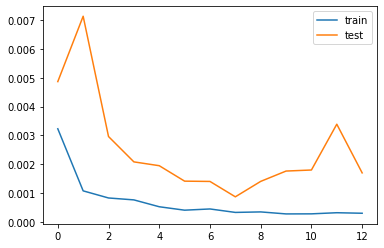

In [ ]:
lstm_model = train_model(
    prep_dsets=prep_dsets, 
    coin_name=cc, 
    model_builder=build_LSTM,
    model_kwargs=dict(
        num_rnns=2,
        dim_rnn=50, 
        dense_units=100, 
        drop=False, 
        drop_rate=0.5,
    ),
    batch_size=1,
    n_epochs=20,
    early_stop=True,
    patience=5
)

In [40]:
# This is what we would call in the dashboard
from app.modules.models_meta import pred_models

model_meta = pred_models['BTC-USD']['1D']['BTC_LSTM_VGC_1D']
model_builder = model_meta['builder']
builder_kwargs = model_meta['model_kwargs']
test_weights_path = model_meta['test_weights_path']
lstm_model = model_builder(in_shape=(model_meta['lags'], model_meta['n_features']), **builder_kwargs)
lstm_model.load_weights(test_weights_path)
test_df = get_test_df(lstm_model, X_test, y_test, scaler, test_dates)
test_fig = plot_model_test(test_df)
#test_fig.update_layout(width=750, height=500)
test_fig.show()
test_df['Scope'] = '1D'
test_df['Ticker'] = cc
test_df['Model'] = 'BTC_LSTM_VGC_1D'
test_df.reset_index().to_csv('./app/dash/test_models/predictions.csv', index=False)

12/12 [==============================] - 0s 15ms/step


In [16]:
lstm_idf = get_importance_df(lstm_model, dsets[cc], timesteps)
figi = plot_importance(lstm_idf)
#fig.update_layout(width=750, height=500)
figi.show()

In [ ]:
model_name = 'BTC_LSTM_VGC_1D'
save_model(full_path=model_name + '.json', model=lstm_model)
preds_df = get_test_df(lstm_model, X_test, y_test, scaler, test_dates)
preds_df['Ticker'] = cc
preds_df['Model'] = model_name
preds_df.to_csv('predictions.csv', index=False)
imp_df = get_importance_df(lstm_model, dsets[cc], timesteps)
imp_df['Model'] = model_name
imp_df['Ticker'] = cc
imp_df.to_csv('ft_importance.csv', index=False)

### BLSTM

In [ ]:
blstm_model = train_model(
    prep_dsets=prep_dsets, 
    coin_name=cc, 
    model_builder=build_BLSTM, 
    model_kwargs=dict(
        num_rnns=2,
        dim_rnn=25, 
        dense_units=50, 
        drop=False,
        drop_rate=0.2
    ),
    n_epochs=30,
    early_stop=True,
    patience=15
)

Epoch 1/30


In [18]:
model_name = 'BTC_BLSTM_VGC_1D'
save_model(full_path=model_name + '.json', model=blstm_model)
preds_df = get_test_df(blstm_model, X_test, y_test, scaler, test_dates)
preds_df['Ticker'] = cc
preds_df['Model'] = model_name
preds_df.to_csv('blstm_predictions.csv', index=False)
imp_df = get_importance_df(blstm_model, dsets[cc], timesteps)
imp_df['Model'] = model_name
imp_df['Ticker'] = cc
imp_df.to_csv('blstm_ft_importance.csv', index=False)

In [ ]:
# This is what we would call in the dashboard
test_df = get_test_df(blstm_model, X_test, y_test, scaler, test_dates)
test_fig = plot_model_test(test_df)
#test_fig.update_layout(width=750, height=500)
test_fig.show()

In [16]:
blstm_idf = get_importance_df(blstm_model, dsets[cc], timesteps)
figi = plot_importance(blstm_idf)
#fig.update_layout(width=750, height=500)
figi.show()

### BLSTM with Attenttion

In [ ]:
ablstm_model = train_model(
    prep_dsets=prep_dsets, 
    coin_name=cc', 
    model_builder=build_AttentiveBLSTM,
    model_kwargs=dict(
        num_rnns=4,
        dim_rnn=50, 
        drop=True, 
        drop_rate=0.5,
        suffix='4RNN_d50'
    ),
    n_epochs=300,
    early_stop=True,
    patience=50    
)

# Prediction and Validation

In [ ]:
# This is what we would call in the dashboard
model = load_model(model_name='blstm', coin_ticker='BTC')
scaler = load_scaler(coin_ticker='BTC')
test_df = get_test_df(model, X_test, y_test, scaler, test_dates)
test_fig = plot_model_test(test_df)
test_fig.update_layout(width=750, height=500)

12/12 [==============================] - 1s 14ms/step


In [ ]:
# This is what we would call in the dashboard
ab_model = build_AttentiveBLSTM(
                        in_shape=(X_train.shape[1], X_train.shape[2]),
                        num_rnns=4,
                        dim_rnn=50,
                        drop=True,
                        drop_rate=0.5,
                        suffix='4RNN_d50'
                        )
ab_model.load_weights('./models/BTC_Attentive_BLSTM_60_lags_3_fts_4RNN_d50.h5')
test_df = get_test_df(ab_model, X_test, y_test, scaler, test_dates)
test_fig = plot_model_test(test_df)
test_fig.update_layout(width=750, height=500)

Model: "Attentive_BLSTM_60_lags_3_fts_4RNN_d50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequential_input (InputLayer)  [(None, 60, 3)]      0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 60, 100)     21600       ['sequential_input[0][0]']       
 l)                                                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 60, 100)      0           ['bidirectional_12[0][0]']       
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 60, 100)     60400   

c:\Users\Priscilla\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



12/12 [==============================] - 4s 33ms/step


# Feature Importance

In [ ]:
blstm_idf = get_importance_df(blstm_model, dsets['Bitcoin'], timesteps)
fig = plot_importance(blstm_idf)
fig.update_layout(width=750, height=500)

In [ ]:
ablstm_idf = get_importance_df(ab_model, dsets['Bitcoin'], timesteps)
fig = plot_importance(ablstm_idf)
fig.update_layout(width=750, height=500)